In [1]:
#default_exp loading

# Data Loading

<br>

### Imports

In [2]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from batopt import utils

import os
import glob

<br>

### User Inputs

In [3]:
raw_data_dir = '../data/raw'

<br>

### Loading the Raw Data

We'll start by loading in the demand data

In [4]:
#exports
def load_training_dataset(raw_data_dir: str, dataset_name: str='demand', parse_dt_idx: bool=True) -> pd.DataFrame:
    allowed_datasets = ['demand', 'pv', 'weather']
    assert dataset_name in allowed_datasets, f"`dataset_name` must be one of: {', '.join(allowed_datasets)} - not {dataset_name}"
    
    df = pd.concat([pd.read_csv(f) for f in glob.glob(f'{raw_data_dir}/{dataset_name}_*.csv')], ignore_index = True)
    
    if parse_dt_idx == True:
        assert 'datetime' in df.columns, 'if `parse_dt_idx` is True then `datetime` must be a column in the dataset'
        
        df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
        df = df.set_index('datetime')

    return df

In [5]:
df_demand = load_training_dataset(raw_data_dir, 'demand')

df_demand.head()

,demand_MW
datetime,
2017-11-03 00:00:00+00:00,2.19
2017-11-03 00:30:00+00:00,2.14
2017-11-03 01:00:00+00:00,2.01
2017-11-03 01:30:00+00:00,1.87
2017-11-03 02:00:00+00:00,1.86


<br>

Then the pv

In [6]:
df_pv = load_training_dataset(raw_data_dir, 'pv')

df_pv.head()

,irradiance_Wm-2,pv_power_mw,panel_temp_C
datetime,,,
2017-11-03 00:00:00+00:00,0.0,0.0,7.05
2017-11-03 00:30:00+00:00,0.0,0.0,7.38
2017-11-03 01:00:00+00:00,0.0,0.0,7.70
2017-11-03 01:30:00+00:00,0.0,0.0,7.48
2017-11-03 02:00:00+00:00,0.0,0.0,7.20


<br>

And finally the weather

In [7]:
df_weather = load_training_dataset(raw_data_dir, 'weather').sort_index(axis=1)

df_weather.head(3)

,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6
datetime,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,9.75,9.65,8.83,7.58,11.62,11.22
2015-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,9.91,9.76,8.90,7.62,11.65,11.32
2015-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,9.99,9.80,9.10,7.61,11.65,11.30


<br>

We'll also create a function that reads all of the datasets in at once and then combines them

In [8]:
#exports
def combine_training_datasets(raw_data_dir):
    df_combined = pd.DataFrame()

    for dataset_name in ['demand', 'pv', 'weather']:
        df_single_dataset = load_training_dataset(raw_data_dir, dataset_name)

        cols_to_be_overwritten = set(df_combined.columns) - (set(df_combined.columns) - set(df_single_dataset.columns))
        assert len(cols_to_be_overwritten) == 0, f"The following columns exist in multiple datasets meaning data would be overwritten: {', '.join(cols_to_be_overwritten)}"

        df_combined = df_combined.append(df_single_dataset)
    
    df_combined = df_combined.sort_index()
    
    return df_combined

In [9]:
df_combined = combine_training_datasets(raw_data_dir)

df_combined.head(3)

,demand_MW,irradiance_Wm-2,pv_power_mw,panel_temp_C,temp_location3,temp_location6,temp_location2,temp_location4,temp_location5,temp_location1,solar_location3,solar_location6,solar_location2,solar_location4,solar_location5,solar_location1
datetime,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,8.83,11.22,9.65,7.58,11.62,9.75,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,8.90,11.32,9.76,7.62,11.65,9.91,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,NaN,NaN,NaN,NaN,9.10,11.30,9.80,7.61,11.65,9.99,0.0,0.0,0.0,0.0,0.0,0.0


<br>

### Missing Values

We'll quickly inspect the datasets and check their coverage over the full date range

In [10]:
#exports
def identify_df_dt_entries(df_demand, df_pv, df_weather):
    min_dt = min(df_demand.index.min(), df_pv.index.min(), df_weather.index.min())
    max_dt = max(df_demand.index.max(), df_pv.index.max(), df_weather.index.max())

    dt_rng = pd.date_range(min_dt, max_dt, freq='30T')
    df_nulls = pd.DataFrame(index=dt_rng)

    df_nulls['demand'] = df_demand.reindex(dt_rng).isnull().mean(axis=1).astype(int)
    df_nulls['pv'] = df_pv.reindex(dt_rng).isnull().mean(axis=1).astype(int)
    df_nulls['weather'] = df_weather.reindex(dt_rng).ffill(limit=1).isnull().mean(axis=1).astype(int)

    df_entries = 1 - df_nulls
    
    return df_entries

<AxesSubplot:>

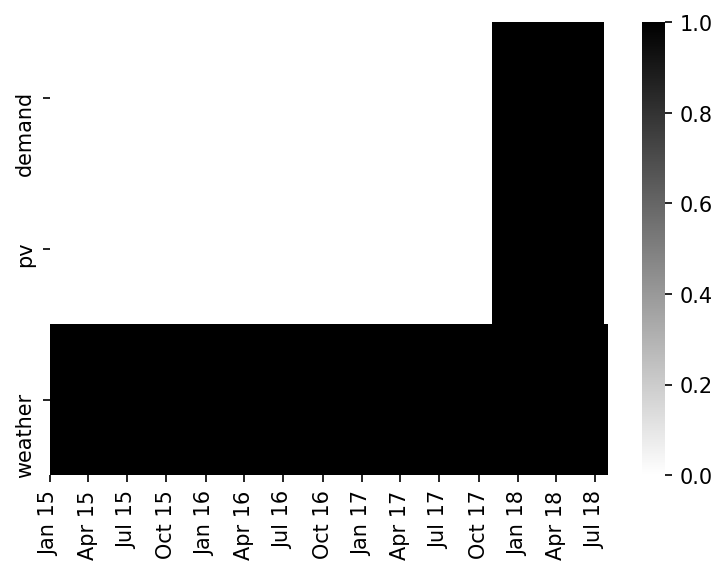

In [11]:
df_entries = identify_df_dt_entries(df_demand, df_pv, df_weather)

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(df_entries.T, ax=ax, cmap=plt.cm.binary)

utils.set_date_ticks(ax, '2015-01-01', '2018-07-31', axis='x', freq='Qs', date_format='%b %y')

<br>

Finally we'll export the relevant code to our `batopt` module

In [12]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-data-loading.ipynb.
